In [15]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

from loss_traces.config import MODEL_DIR
from loss_traces.data_processing.data_processing import (
    get_no_shuffle_train_loader,
    get_num_classes,
)
from loss_traces.models.model import load_model
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.results.result_processing import (
    get_attackr_scores,
    get_lira_scores,
    get_rmia_scores,
    get_trace_reduction,
)
from loss_traces.results.utils import (
    make_precision_recall_at_k_df_single_threshold,
    make_precision_recall_at_k_df,
)
from loss_traces.attacks import AttackConfig, RMIAAttack
from sklearn.metrics import roc_curve

plt.style.use("plot_style.mplstyle")

This notebook renders the main results relevant to our main setup (WRN28-2, CIFAR-10).

In [2]:
exp_id = "wrn28-2_CIFAR10"

config = {
    "dataset": "CIFAR10",
    "arch": "wrn28-2",
    "batchsize": 16,
    "num_workers": 4,
    "augment": True,
    "device": "cuda:1",
}


def _initialize_model_and_data(config):
    attack_loaders = [
        get_no_shuffle_train_loader(
            config["dataset"],
            config["arch"],
            config["batchsize"],
            config["num_workers"],
        )
    ]

    if config["augment"]:
        attack_loaders.append(
            get_no_shuffle_train_loader(
                config["dataset"],
                config["arch"],
                config["batchsize"],
                config["num_workers"],
                mirror_all=True,
            )
        )

    model = load_model(config["arch"], get_num_classes(config["dataset"])).to(
        config["device"]
    )

    return model, attack_loaders


saves = torch.load(f"{MODEL_DIR}/{exp_id}/target", weights_only=False)

model, data_loader = _initialize_model_and_data(config)
model.load_state_dict(saves["model_state_dict"])

if not os.path.exists(f"fin_losses_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["loss"]).to_csv(
        f"fin_losses_{exp_id}_0.csv"
    )
if not os.path.exists(f"grads_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["grads"]).to_csv(
        f"grads_{exp_id}_0.csv"
    )
if not os.path.exists(f"shap_{exp_id}_0.csv"):
    get_final_model_metrics(model, data_loader[0], metrics=["shap"]).to_csv(
        f"shap_{exp_id}_0.csv"
    )


# Table 5

In [6]:
def precision_on_union(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]

    benchmarks = ['lira_score', 'attackr_score', 'rmia_score']
    members = df[df['target_trained_on'] == True]
    members_dict = set()
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
            
        fprs, _tprs, thresholds = roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]  
        members_dict.update(vulnerable.index)

    if random_guessing:
        return sum(members[attack_score] >= threshold)/len(members), n, sum(members[attack_score] >= threshold)

    top_k = top_score.head(n)

    tp = len(set(top_k.index) & members_dict)

    return float(tp) / len(top_k), n, sum(members[attack_score] >= threshold)

    
def recall_on_union(df, k, members, top_score, level, attack_score="lira_score", random_guessing=False):
    n = int(k * (len(members) / 100.0))
    attack_scores = df[attack_score]

    benchmarks = ['lira_score', 'attackr_score', 'rmia_score']
    members = df[df['target_trained_on'] == True]
    members_dict = set()
    
    for attack_score in benchmarks:
        
        attack_scores = df[attack_score]
            
        fprs, _tprs, thresholds = roc_curve(df['target_trained_on'], attack_scores, drop_intermediate=False)
        threshold = thresholds[np.where(fprs <= level)[0][-1]]

        vulnerable = members.loc[members[attack_score] >= threshold][attack_score]  
        members_dict.update(vulnerable.index)

    top_k = top_score.head(n)

    if random_guessing:
        return float(k)/100

    tp = len(set(top_k.index) & members_dict)
    neg = len(members_dict)

    return tp / neg if neg else 0

In [7]:
exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id)
df["attackr_score"] = get_attackr_scores(exp_id)
df["rmia_score"] = get_rmia_scores(exp_id, "target", return_full_df=False)


df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
df["param_grads"] = pd.read_csv(f"grads_{exp_id}_0.csv")["param_grad_norm"]
df["input_grads"] = pd.read_csv(f"grads_{exp_id}_0.csv")["input_grad_norm"]
df["shap"] = pd.read_csv(f"shap_{exp_id}_0.csv")["shap_norm"]
df["confidence"] = pd.read_csv(f"fin_losses_{exp_id}_0.csv")["confidence"]
df["loss"] = pd.read_csv(f"fin_losses_{exp_id}_0.csv")["loss"]

members = df[df['target_trained_on'] == True]
top_score = members.sort_values(by='rmia_score', ascending=False)

level = 0.001


metrics_to_check = ['loss', 'lt_iqr', 'confidence', 'param_grads', 'input_grads', 'shap']
results = []

k=1
for metric in metrics_to_check:
    top_score = members.sort_values(by=metric, ascending=False)
    if metric == "confidence":
        top_score = top_score.sort_values(by=metric, ascending=True)
    precision = precision_on_union(df, k, members, top_score, 0.001)[0]
    recall = recall_on_union(df, k, members, top_score, 0.001)
    results.append({
        'Metric': metric,
        'Precision on union': precision,
        'Recall on union': recall
    })

results_df = pd.DataFrame(results)
display(results_df)

,Metric,Precision on union,Recall on union
0,loss,0.208,0.019931
1,lt_iqr,0.932,0.089306
2,confidence,0.200,0.019164
3,param_grads,0.204,0.019548
4,input_grads,0.204,0.019548
5,shap,0.160,0.015332


# Table 1

In [8]:
make_precision_recall_at_k_df_single_threshold(
    scores_df=df,
    ground_truth_df=df,
    fpr_threshold=0.001,
    k_frac=0.01,
)

metrics = [
    "loss_desc",
    "param_grads_desc",
    "input_grads_desc",
    "shap_desc",
    "lt_iqr_desc",
]
results = {metric: {} for metric in metrics}
k_fracs = [0.01, 0.03, 0.05, 0.10, 0.20, 0.50]

for k_frac in k_fracs:
    stats = make_precision_recall_at_k_df_single_threshold(
        scores_df=df,
        ground_truth_df=df,
        fpr_threshold=0.001, 
        k_frac=k_frac
    )
    
    for metric in metrics:
        results[metric][f'k={k_frac*100}% Precision'] = stats[f'precision_{metric}']
        results[metric][f'k={k_frac*100}% Recall'] = stats[f'recall_{metric}']

results_df = pd.DataFrame.from_dict(results, orient='index')

column_order = []
for k_frac in k_fracs:
    column_order.extend([f'k={k_frac*100}% Precision', f'k={k_frac*100}% Recall'])
results_df = results_df[column_order]

display(results_df)


,k=1.0% Precision,k=1.0% Recall,k=3.0% Precision,k=3.0% Recall,k=5.0% Precision,k=5.0% Recall,k=10.0% Precision,k=10.0% Recall,k=20.0% Precision,k=20.0% Recall,k=50.0% Precision,k=50.0% Recall
loss_desc,0.208,0.021346,0.196000,0.060345,0.2008,0.103038,0.2008,0.206076,0.1902,0.390394,0.14520,0.745074
param_grads_desc,0.200,0.020525,0.192000,0.059113,0.2120,0.108785,0.2140,0.219622,0.2032,0.417077,0.15272,0.783662
input_grads_desc,0.204,0.020936,0.196000,0.060345,0.2064,0.105911,0.2152,0.220854,0.2046,0.419951,0.15496,0.795156
shap_desc,0.144,0.014778,0.141333,0.043514,0.1400,0.071839,0.1348,0.138342,0.1254,0.257389,0.11448,0.587438
lt_iqr_desc,0.920,0.094417,0.829333,0.255337,0.7600,0.389984,0.5960,0.611658,0.4214,0.864943,0.19408,0.995895


# Figure 1

In [10]:
# First, we need to run RMIA with 2 shadow models

dataset = "CIFAR10"
arch = "wrn28-2"
exp_id = f"{arch}_{dataset}"

config = AttackConfig(
    exp_id=exp_id,
    target_id="target",
    checkpoint=None,
    arch=arch,
    dataset=dataset,
    attack="RMIA",
    augment=True,
    batchsize=32,
    num_workers=8,
    gpu=":1",
    n_shadows=1,
)
attack = RMIAAttack(config)
results = attack.run()

n_shadows=1, in_confs=1, out_confs=1
Attack AUC: 0.6680268872


In [53]:
df["rmia_1"] = results["rmia_2.0_new_score"]

In [54]:
df_res = make_precision_recall_at_k_df(
    scores_df=df,
    ground_truth_df=df,
    k_frac=0.01,
)

19492it [01:21, 239.11it/s]


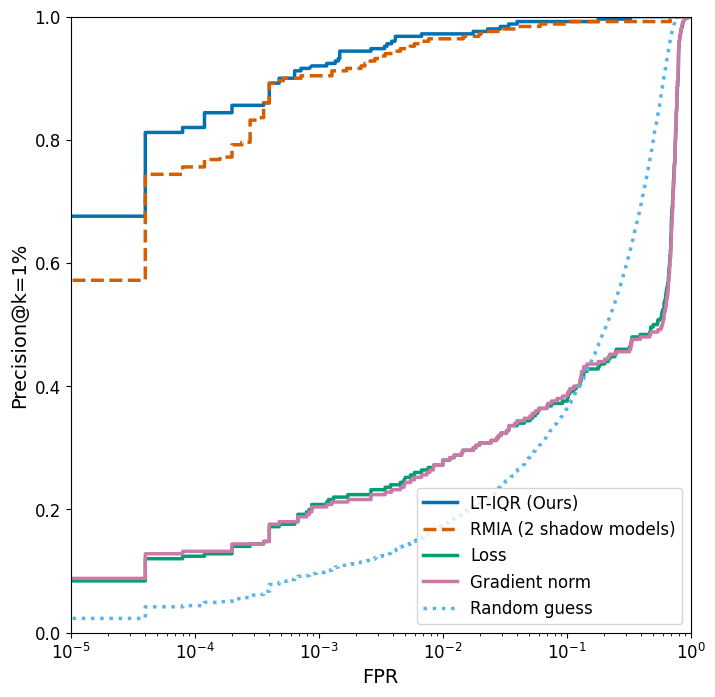

In [55]:
plt.figure(figsize=(8, 8))

plt.plot(
    df_res["fpr"],
    df_res["precision_lt_iqr_desc"],
    linewidth=2.5,
    color="#0072B2",
    label="LT-IQR (Ours)",
)
plt.plot(
    df_res["fpr"],
    df_res["precision_rmia_1_desc"],
    linewidth=2.5,
    color="#D55E00",
    linestyle="--",
    label="RMIA (2 shadow models)",
)
plt.plot(
    df_res["fpr"],
    df_res["precision_loss_desc"],
    linewidth=2.5,
    color="#009E73",
    label="Loss",
)
plt.plot(
    df_res["fpr"],
    df_res["precision_input_grads_desc"],
    linewidth=2.5,
    color="#CC79A7",
    label="Gradient norm",
)
plt.plot(
    df_res["fpr"],
    df_res["precision_random_guess"],
    linewidth=2.5,
    color="#56B4E9",
    linestyle=":",
    label="Random guess",
)
plt.xscale("log")
plt.ylim((0))
plt.xlim(1e-5, 1)

plt.xlabel("FPR")
plt.ylabel(f"Precision@k={k}%")

plt.legend(loc="lower right", fontsize=12, prop={"size": 12})

plt.show()

# Figures 7 and 8

In [57]:
dfs = {}
for k in (0.001, 0.01, 0.02, 0.03, 0.05):
    dfs[k] = make_precision_recall_at_k_df(
    scores_df=df,
    ground_truth_df=df,
    k_frac=k,
)

19492it [01:17, 252.27it/s]
19492it [01:23, 233.53it/s]
19492it [01:30, 215.50it/s]
19492it [01:40, 194.60it/s]
19492it [01:53, 171.60it/s]


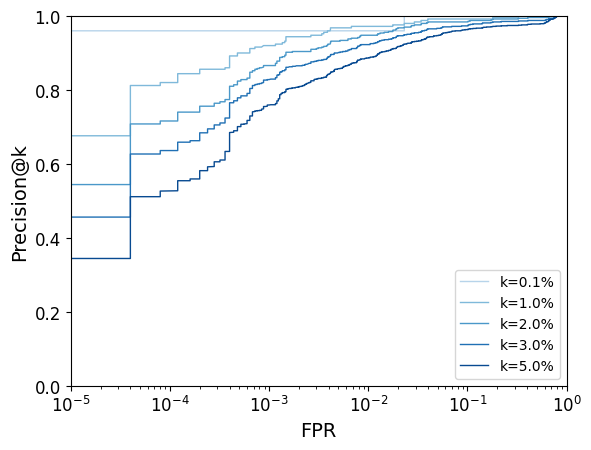

In [74]:
blues = plt.cm.Blues(np.linspace(0.3, 0.9, 5))  # Light to dark blue using built-in colormap
for i, k in enumerate((0.001, 0.01, 0.02, 0.03, 0.05)):
    plt.plot(
        dfs[k]["fpr"],
        dfs[k]["precision_lt_iqr_desc"],
        linewidth=1,
        color=blues[i],
        label=f"k={k*100:.1f}%",
    )

plt.xscale("log")
plt.ylim((0,1))
plt.xlim(1e-5, 1)

plt.xlabel("FPR")
plt.ylabel("Precision@k")

plt.legend(loc="lower right")
plt.show()

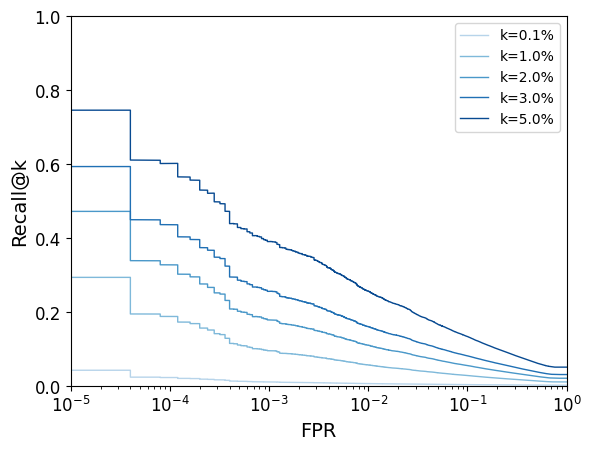

In [76]:
blues = plt.cm.Blues(np.linspace(0.3, 0.9, 5))  # Light to dark blue using built-in colormap
for i, k in enumerate((0.001, 0.01, 0.02, 0.03, 0.05)):
    plt.plot(
        dfs[k]["fpr"],
        dfs[k]["recall_lt_iqr_desc"],
        linewidth=1,
        color=blues[i],
        label=f"k={k*100:.1f}%",
    )

plt.xscale("log")
plt.ylim((0,1))
plt.xlim(1e-5, 1)

plt.xlabel("FPR")
plt.ylabel("Recall@k")

plt.legend(loc="upper right")
plt.show()

In [79]:
df

,og_idx,lira_score,target_trained_on,attackr_score,rmia_score,lt_iqr,param_grads,input_grads,shap,confidence,loss,rmia_1
0,0,1.575831e+00,True,0.578645,615,0.037929,0.005427,0.000325,1.725301,22.433048,2.515284e-05,769
1,1,1.287779e+00,True,0.728682,734,0.000241,0.000146,0.000005,1.594403,28.949955,7.152555e-07,1104
2,2,9.335247e-01,False,0.270574,489,0.179490,0.054539,0.005295,2.334620,17.597404,1.777253e-04,651
3,3,1.644933e+00,True,0.071556,387,0.003998,0.010066,0.000721,1.682935,20.646503,4.327204e-05,516
4,4,1.167078e+00,False,0.066395,471,0.000282,0.035568,0.001540,1.511879,17.301975,3.181190e-04,488
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,8.321130e-09,False,0.687226,44,2.071802,339.908478,26.279928,1.150077,1.867180,5.646396e+00,43
49996,49996,7.083908e-03,False,0.705020,416,1.052571,10.351227,0.738444,1.892762,7.588379,2.423868e-02,459
49997,49997,7.551356e+00,True,0.934450,690,0.675529,1.510588,0.120953,2.126289,11.244856,5.236481e-03,829
49998,49998,1.004162e+00,True,0.110666,500,0.000269,0.015010,0.000699,1.328020,19.196409,1.103817e-04,466


# Figure 11

Spearman correlation between trace values and LIRA scores: 0.616


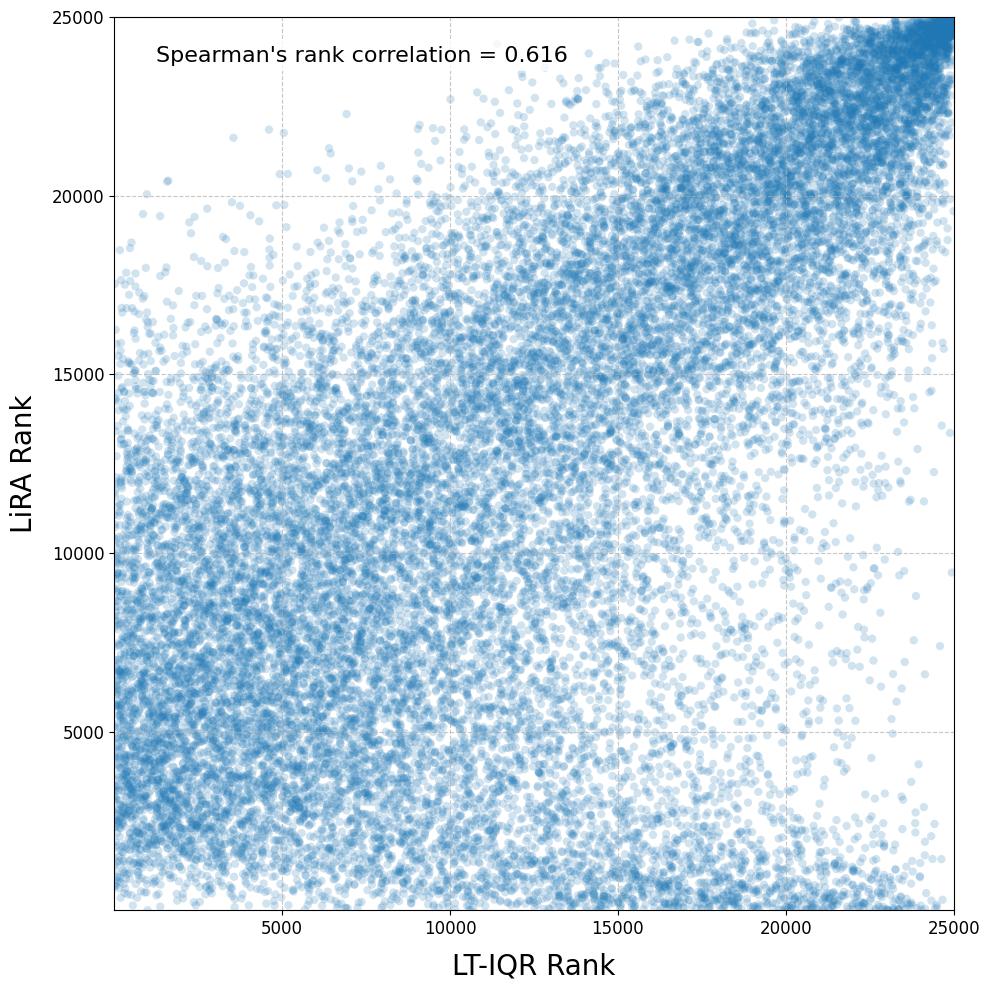

In [81]:
correlation = df[df["target_trained_on"]]["lt_iqr"].corr(
    df[df["target_trained_on"]]["lira_score"], method="spearman"
)

print(f"Spearman correlation between trace values and LIRA scores: {correlation:.3f}")

plt.figure(figsize=(10, 10))
plt.scatter(
    df[df["target_trained_on"]]["lt_iqr"]
    .rank()
    .sample(n=25000, random_state=42),
    df[df["target_trained_on"]]["lira_score"]
    .rank()
    .sample(n=25000, random_state=42),
    alpha=0.2,
    color='#1f77b4',
    edgecolor='none'
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("LT-IQR Rank", fontsize=20, labelpad=10)
plt.ylabel("LiRA Rank", fontsize=20, labelpad=10)

# Add correlation text to plot
plt.text(0.05, 0.95, f"Spearman's rank correlation = {correlation:.3f}", 
         transform=plt.gca().transAxes,
         fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
